In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.lib.function_base import hamming
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Load the diabetes dataset
data = pd.read_excel("/content/diabetes_filtered.xlsx")  # Replace "diabetes.xlsx" with the actual filename

# Step 2: Separate features (X) and target variable (y)
X = data.iloc[:,:-1]#df.drop("Outcome", axis=1)
y = data.iloc[:,-1]#df["Outcome"]
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000
...,...,...,...,...,...,...,...,...
696,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000
697,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000
698,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000
699,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)
X


array([[0.35294118, 0.74371859, 0.59016393, ..., 0.50074516, 0.23441503,
        0.48333333],
       [0.05882353, 0.42713568, 0.54098361, ..., 0.39642325, 0.11656704,
        0.16666667],
       [0.47058824, 0.91959799, 0.52459016, ..., 0.34724292, 0.25362938,
        0.18333333],
       ...,
       [0.29411765, 0.6080402 , 0.59016393, ..., 0.390462  , 0.07130658,
        0.15      ],
       [0.05882353, 0.63316583, 0.49180328, ..., 0.4485842 , 0.11571307,
        0.43333333],
       [0.05882353, 0.46733668, 0.57377049, ..., 0.45305514, 0.10119556,
        0.03333333]])

In [ ]:
#Reduksi Noise dengan K-NN
# Calculate distances using k = 3 nearest neighbors
k = 3
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X)
distances, indices = knn.kneighbors(X)

# Retrieve labels for each neighbor
neighbor_labels = []
for neighbor_indices in indices:
    neighbor_labels.append(y.iloc[neighbor_indices].tolist())

# Calculate proportions of neighbors from the same and opposite classes
same_class_count = []
opposite_class_count = []
for i, neighbors in enumerate(neighbor_labels):
    same_class_count.append(sum(neighbors == y[i]))
    opposite_class_count.append(k - same_class_count[-1])  # Calculate opposite class count

# Assign labels based on the proportions
labels = []
for same, opposite in zip(same_class_count, opposite_class_count):
    if same in [2,3]:
        labels.append('S')
    #elif same == 1 and opposite == 2:
       #labels.append('N')
    #elif same == 0 and opposite == 3:
       #labels.append('N')
    else:
        labels.append('N')

# Add labels to the dataset
data['neighborhood_label'] = labels

# Filter out instances labeled as "Noise" (N) from the minority class
diabetes_filtered = data[~((data['Outcome'] == 0) & (data['neighborhood_label'] == 'N'))]

# Now diabetes_filtered contains only instances labeled as "Noise" (N) from the minority class deleted, while retaining all instances from the majority class
diabetes_filtered
#diabetes_filtered['Surv_status'].value_counts()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,neighborhood_label
0,6,148,72,35,0,33.6,0.627,50,1,S
1,1,85,66,29,0,26.6,0.351,31,0,S
2,8,183,64,0,0,23.3,0.672,32,1,S
3,1,89,66,23,94,28.1,0.167,21,0,S
4,0,137,40,35,168,43.1,2.288,33,1,S
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,S
764,2,122,70,27,0,36.8,0.340,27,0,S
765,5,121,72,23,112,26.2,0.245,30,0,S
766,1,126,60,0,0,30.1,0.349,47,1,S


Data Pima Indian Diabetes

In [ ]:
# Define your custom Manhattan distance function
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def euclidean_distance(x1, x2):
    if len(x1) != len(x2):
      raise ValueError("Points must have the same dimensionality")

    return np.sqrt(np.sum((x2 - x1) ** 2))

def correlation_distance(x1, x2):

    # Calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(x1, x2)[0, 1]

    # Convert correlation coefficient to distance
    correlation_distance = 1.0 - correlation_coefficient

    return correlation_distance


import numpy as np

def mahalanobis_manhattan_distance(x, y, cov_matrix):
    # Pastikan x dan y adalah numpy arrays
    x = np.array(x)
    y = np.array(y)

    # Hitung perbedaan absolut antara x dan y
    diff = np.abs(x - y)

    # Hitung invers dari matriks kovariansi
    cov_inv = np.linalg.inv(cov_matrix)

    # Hitung Mahalanobis Manhattan Distance
    distance = np.sum(np.sqrt(np.dot(diff.T, np.dot(cov_inv, diff))))

    return distance


# Hitung jarak
#distance = mahalanobis_manhattan_distance(x, y, cov_matrix)
#print("Mahalanobis Manhattan Distance:", distance)


k_neighbors = NearestNeighbors(n_neighbors=5, metric=manhattan_distance)

# Fit the Nearest Neighbors classifier on your data
#k_neighbors.fit(X)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()#k_neighbors=k_neighbors

X_resampled, y_resampled = smote.fit_resample(X,y)

X_resampled

array([[0.        , 0.54545455, 0.01923077],
       [0.        , 0.36363636, 0.05769231],
       [0.        , 0.63636364, 0.        ],
       ...,
       [0.43396226, 0.05160539, 0.06600655],
       [0.84604483, 0.63636364, 0.04961177],
       [0.38434867, 0.06621939, 0.03846154]])

Cluster 0: Minority Class Ratio - 0.48, Majority Class Ratio - 0.52
Cluster 1: Minority Class Ratio - 0.20, Majority Class Ratio - 0.80


,count
1,500
0,500


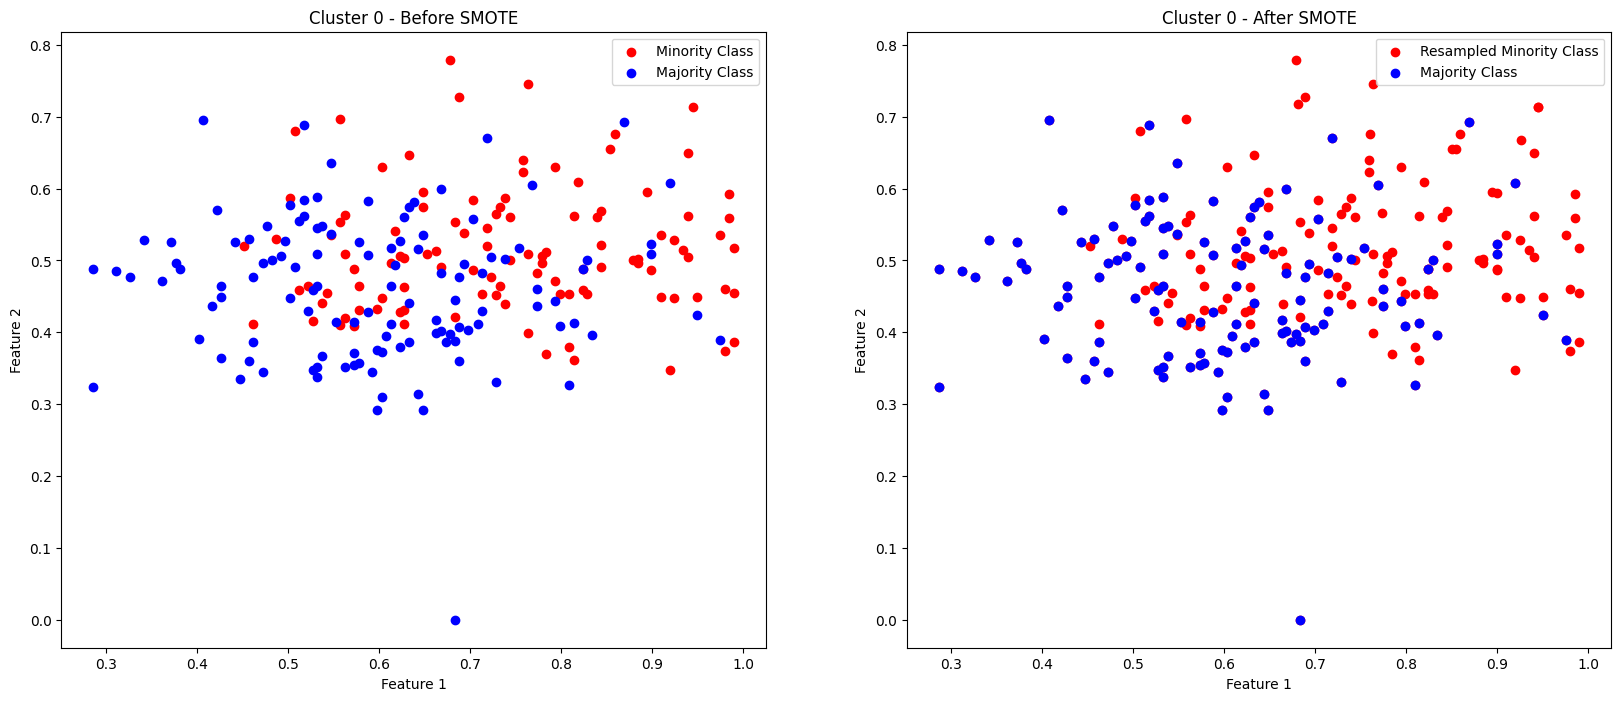

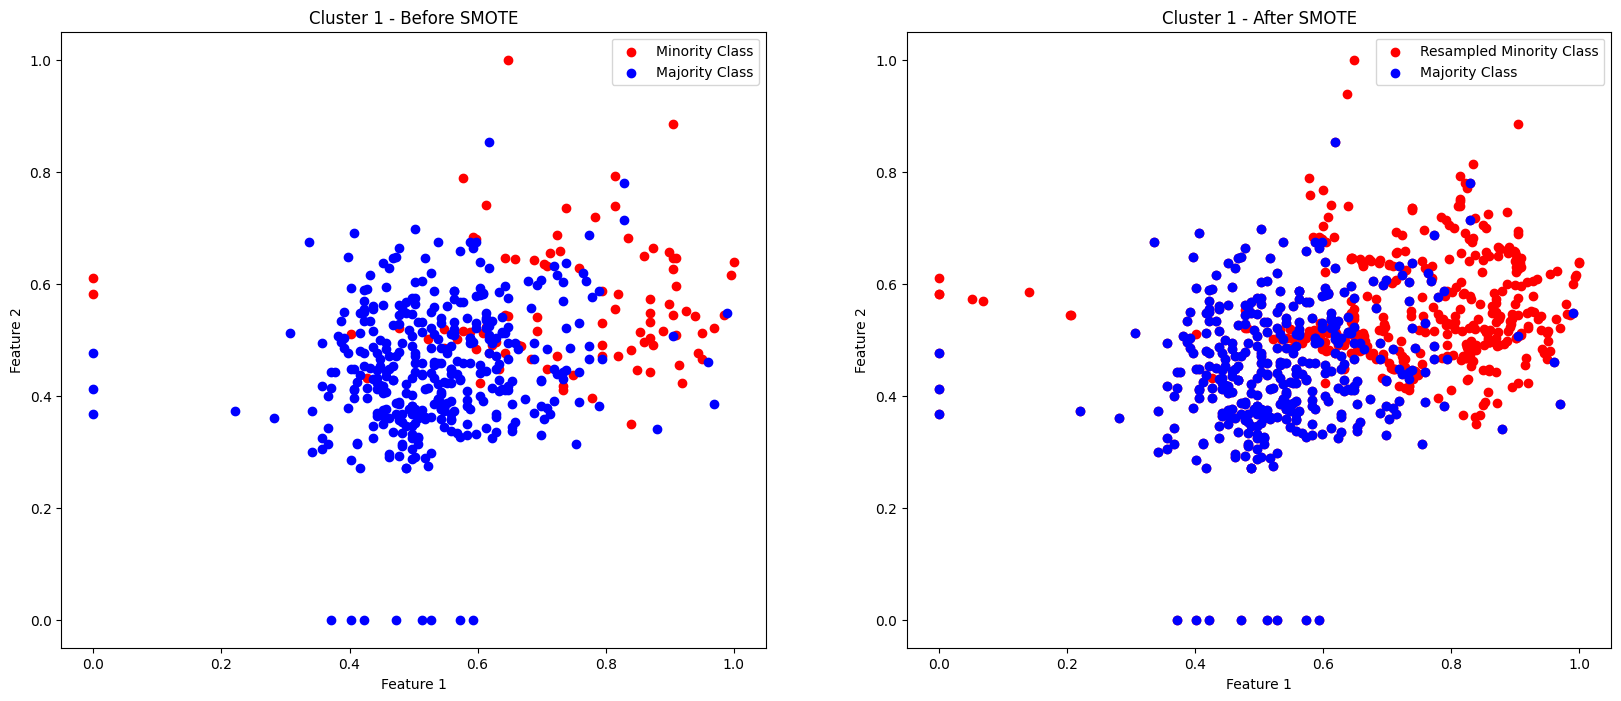

In [ ]:

# Step 3: Perform K-Means clustering

#data = pd.concat([Xs,ys], axis=1)

x = data.iloc[:,:-1]#df.drop("Outcome", axis=1)
y = data.iloc[:,-1]#df["Outcome"]
kmeans = KMeans(n_clusters=2)  # Specify the number of clusters
kmeans.fit(x)

# Step 4: Get the cluster labels
cluster_labels = kmeans.labels_

# Step 5: Assign each sample in X to its nearest cluster centroid
X_clustered = pd.concat([x, pd.Series(cluster_labels, name='cluster')], axis=1)

X_resampled = pd.DataFrame()
y_resampled = pd.Series(dtype=int)

# Step 6: Apply SMOTE to the minority class within each cluster and visualize
for cluster_id in range(kmeans.n_clusters):
    cluster_samples = X_clustered[X_clustered['cluster'] == cluster_id]
    cluster_samples_X = cluster_samples.drop(['cluster'], axis=1)
    cluster_samples_y = y[cluster_samples.index]

    minority_class = cluster_samples_y.value_counts().idxmin()
    minority_samples_X = cluster_samples_X[cluster_samples_y == minority_class]
    minority_samples_y = cluster_samples_y[cluster_samples_y == minority_class]

    majority_class = cluster_samples_y.value_counts().idxmax()
    majority_samples_X = cluster_samples_X[cluster_samples_y == majority_class]
    majority_samples_y = cluster_samples_y[cluster_samples_y == majority_class]

    # Calculate the minority and majority class ratios
    minority_ratio = len(minority_samples_X) / len(cluster_samples_X)
    majority_ratio = len(majority_samples_X) / len(cluster_samples_X)
    print(f"Cluster {cluster_id}: Minority Class Ratio - {minority_ratio:.2f}, Majority Class Ratio - {majority_ratio:.2f}")

    if (minority_ratio >= 0.01)&(len(minority_samples_X) > 0):
    #if ((minority_ratio > 0.15)&(minority_ratio <= 0.7)) :
        # Apply SMOTE to the minority class

        #smote = SMOTE(sampling_strategy='minority')
        #X_resampled_cluster, y_resampled_cluster = smote.fit_resample(cluster_samples_X, cluster_samples_y)
        smote = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=k_neighbors)
        X_resampled_cluster, y_resampled_cluster =  smote.fit_resample(cluster_samples_X, cluster_samples_y)

    else:
        X_resampled_cluster = cluster_samples_X
        y_resampled_cluster = cluster_samples_y

    X_resampled = pd.concat([X_resampled, X_resampled_cluster], axis=0)
    y_resampled = pd.concat([y_resampled, y_resampled_cluster], axis=0)


# Visualize scatter plot before and after SMOTE
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(minority_samples_X['Glucose'], minority_samples_X['BMI'], color='red', label='Minority Class')
    plt.scatter(majority_samples_X['Glucose'], majority_samples_X['BMI'], color='blue', label='Majority Class')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Cluster {cluster_id} - Before SMOTE')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled_cluster['Glucose'], X_resampled_cluster['BMI'], color='red', label='Resampled Minority Class')
    plt.scatter(majority_samples_X['Glucose'], majority_samples_X['BMI'], color='blue', label='Majority Class')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Cluster {cluster_id} - After SMOTE')
    plt.legend()


y_resampled.value_counts()

Text(0.5, 1.0, 'Balanced Data Results of the Noise Reduction With Clustering SMOTE Method ')

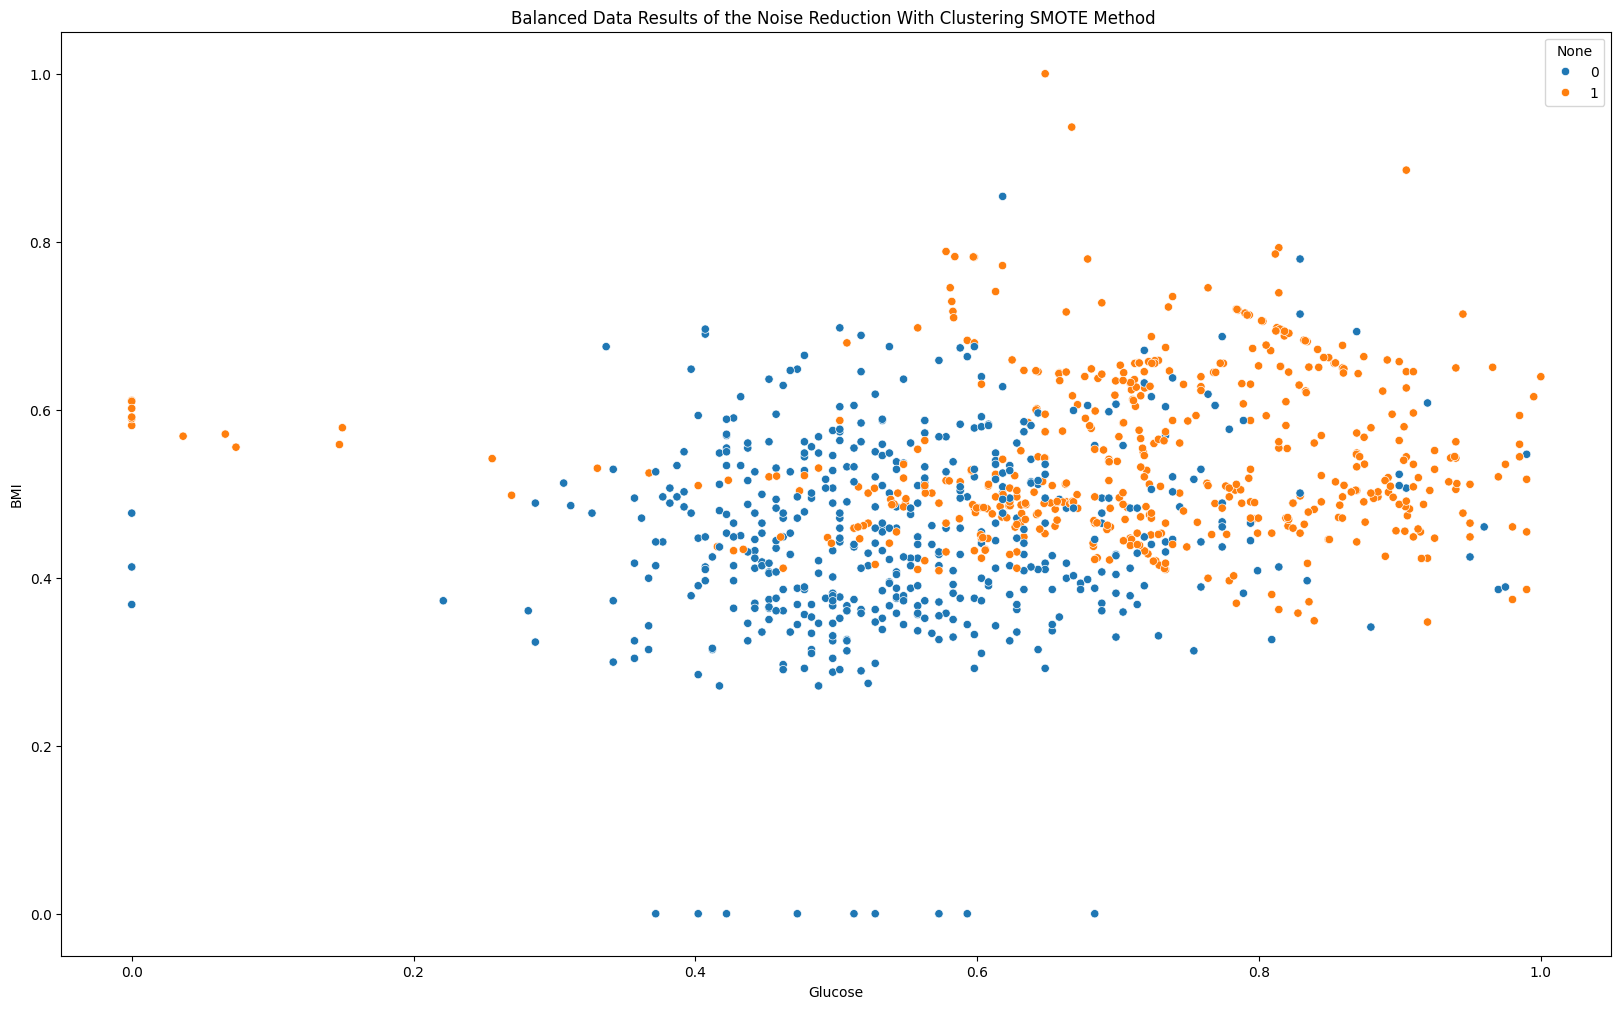

In [ ]:
#Visualisasi Data
plt.figure(figsize=(20, 12))

#Hasil Hybrid Samling Cluster-SMOTE pada Dataset
sns.scatterplot(x = X_resampled['Glucose'], y = X_resampled['BMI'], hue = y_resampled)
plt.title("Balanced Data Results of the Noise Reduction With Clustering SMOTE Method ") #(Manhattan Distance)

#Haberman

In [ ]:
# Load the diabetes dataset
data = pd.read_csv("/content/haberman.csv")  # Replace "diabetes.xlsx" with the actual filename

# Step 2: Separate features (X) and target variable (y)
X = data.iloc[:,:-1]#df.drop("Outcome", axis=1)
y = data.iloc[:,-1]#df["Outcome"]

In [ ]:
# Define your custom Manhattan distance function
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def euclidean_distance(x1, x2):
    if len(x1) != len(x2):
      raise ValueError("Points must have the same dimensionality")

    return np.sqrt(np.sum((x2 - x1) ** 2))

def correlation_distance(x1, x2):

    # Calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(x1, x2)[0, 1]

    # Convert correlation coefficient to distance
    correlation_distance = 1.0 - correlation_coefficient

    return correlation_distance


k_neighbors = NearestNeighbors(n_neighbors=5, metric=euclidean_distance)

# Fit the Nearest Neighbors classifier on your data
#k_neighbors.fit(X)

# Perform SMOTE with Manhattan distance
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=10,k_neighbors=k_neighbors)

#X_resampled, y_resampled = smote.fit_resample(X,y)

#X_resampled


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: Minority Class Ratio - 0.14, Majority Class Ratio - 0.86
Cluster 1: Minority Class Ratio - 0.12, Majority Class Ratio - 0.88
Cluster 2: Minority Class Ratio - 0.18, Majority Class Ratio - 0.82
1    225
2    225
dtype: int64


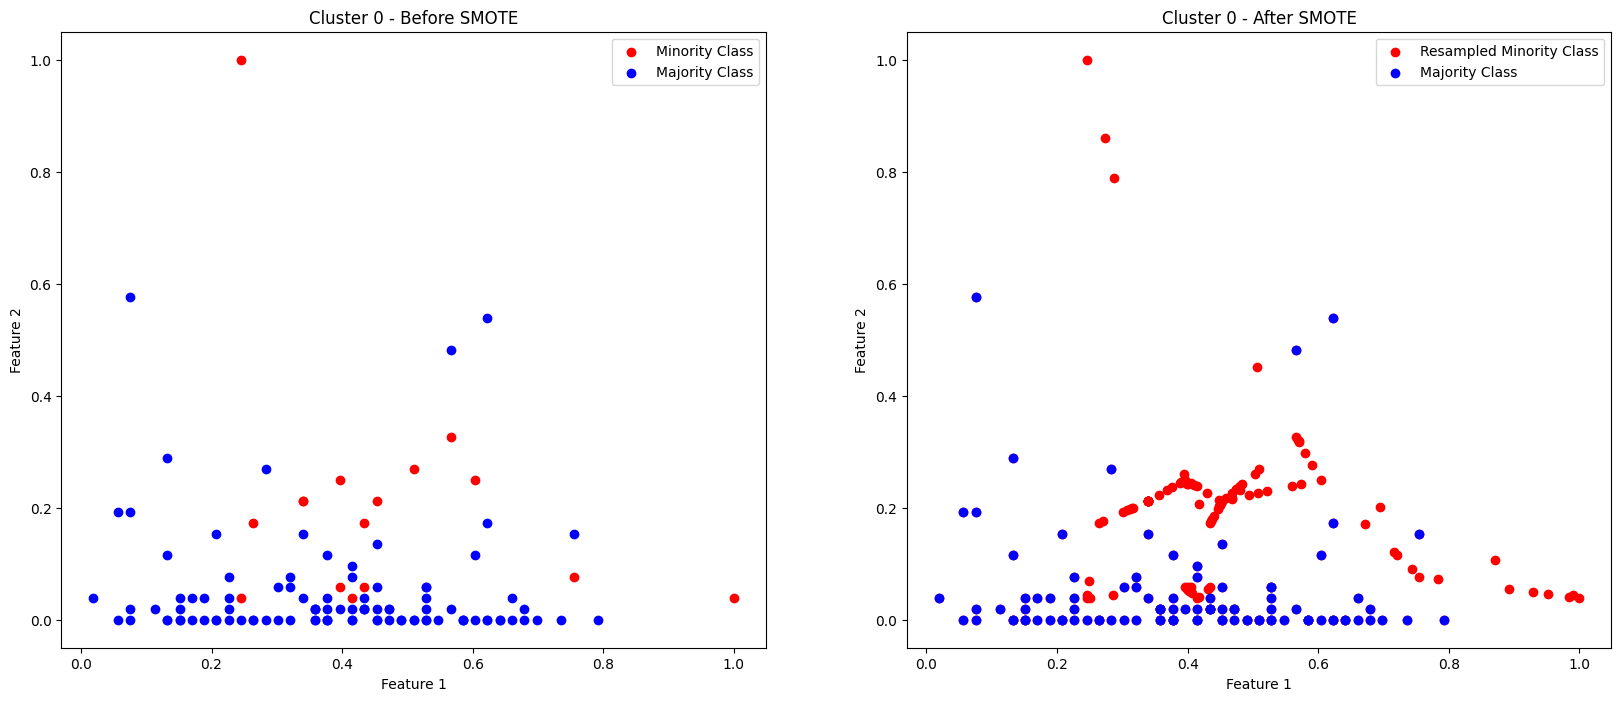

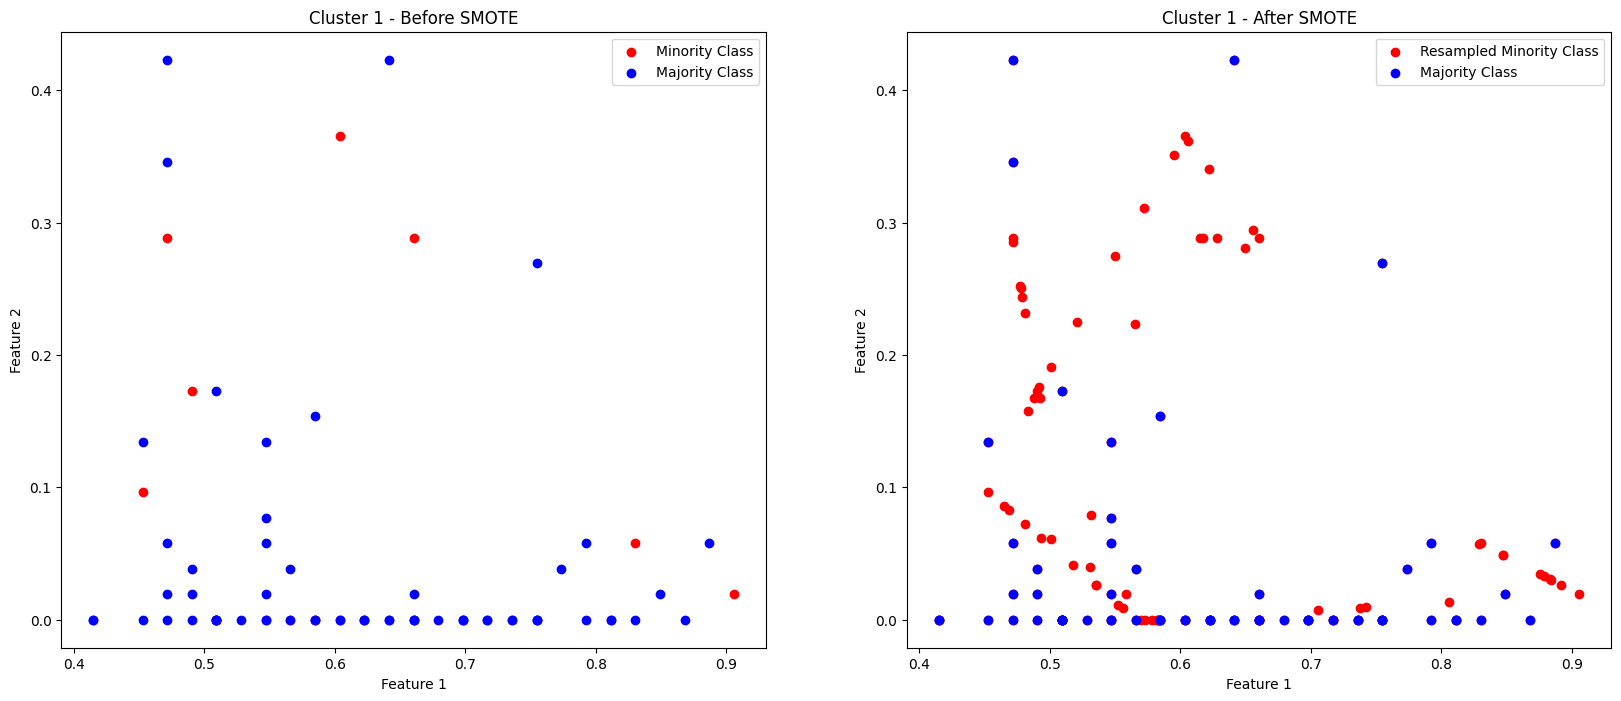

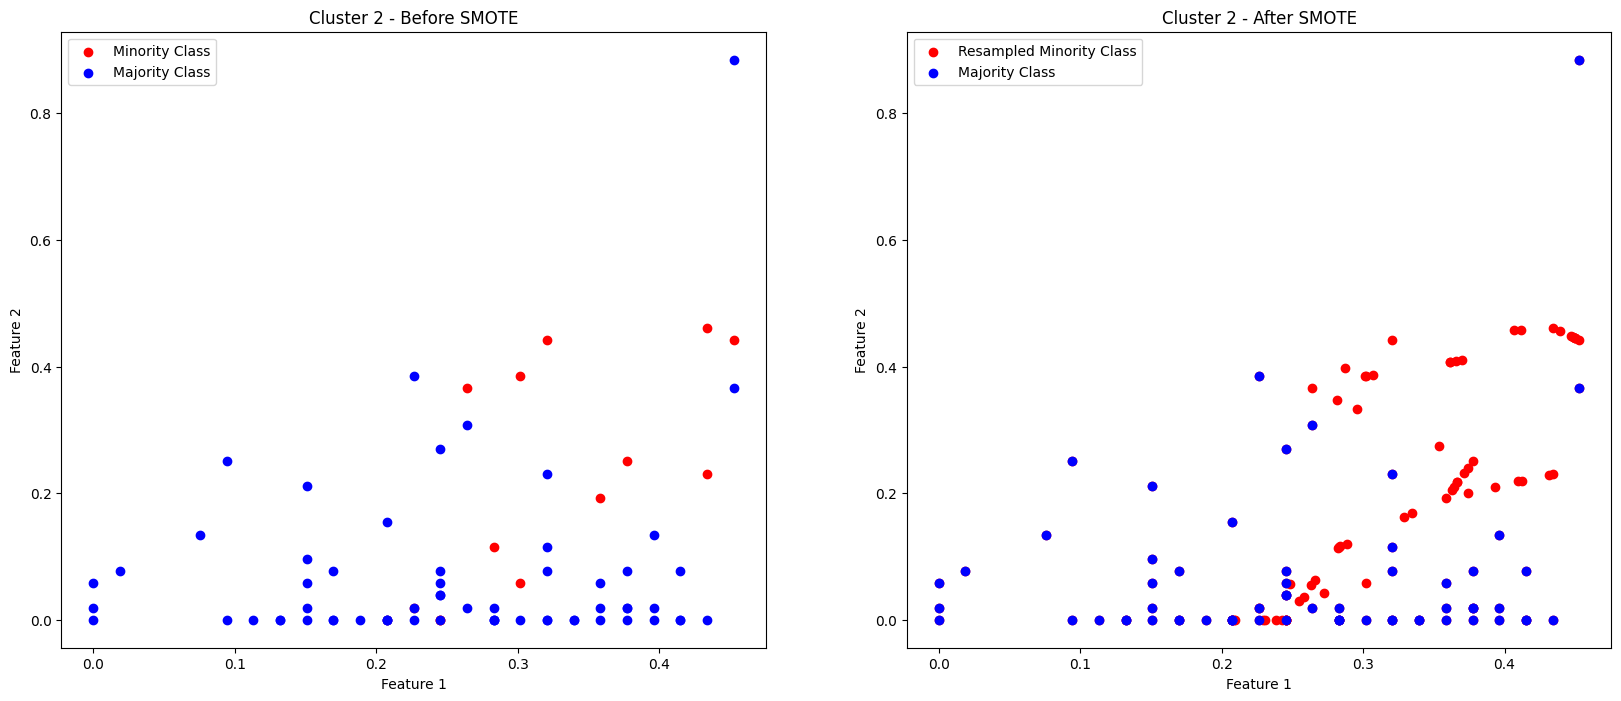

In [ ]:
# Define your custom Manhattan distance function
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def euclidean_distance(x1, x2):
    if len(x1) != len(x2):
      raise ValueError("Points must have the same dimensionality")

    return np.sqrt(np.sum((x2 - x1) ** 2))

def correlation_distance(x1, x2):

    # Calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(x1, x2)[0, 1]

    # Convert correlation coefficient to distance
    correlation_distance = 1.0 - correlation_coefficient

    return correlation_distance


k_neighbors = NearestNeighbors(n_neighbors=3, metric=euclidean_distance)

# Fit the Nearest Neighbors classifier on your data
#k_neighbors.fit(X)

# Perform SMOTE with Manhattan distance
#from imblearn.over_sampling import SMOTE
#smote_manhattan = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)

#X_resampled, y_resampled = smote_manhattan.fit_resample(X, Y)

#X_resampled



# Step 3: Perform K-Means clustering

#data = pd.concat([Xs,ys], axis=1)

x = data.iloc[:,:-1]#df.drop("Outcome", axis=1)
y = data.iloc[:,-1]#df["Outcome"]
kmeans = KMeans(n_clusters=3)  # Specify the number of clusters
kmeans.fit(x)

# Step 4: Get the cluster labels
cluster_labels = kmeans.labels_

# Step 5: Assign each sample in X to its nearest cluster centroid
X_clustered = pd.concat([x, pd.Series(cluster_labels, name='cluster')], axis=1)

X_resampled = pd.DataFrame()
y_resampled = pd.Series(dtype=int)

# Step 6: Apply SMOTE to the minority class within each cluster and visualize
for cluster_id in range(kmeans.n_clusters):
    cluster_samples = X_clustered[X_clustered['cluster'] == cluster_id]
    cluster_samples_X = cluster_samples.drop(['cluster'], axis=1)
    cluster_samples_y = y[cluster_samples.index]

    minority_class = cluster_samples_y.value_counts().idxmin()
    minority_samples_X = cluster_samples_X[cluster_samples_y == minority_class]
    minority_samples_y = cluster_samples_y[cluster_samples_y == minority_class]

    majority_class = cluster_samples_y.value_counts().idxmax()
    majority_samples_X = cluster_samples_X[cluster_samples_y == majority_class]
    majority_samples_y = cluster_samples_y[cluster_samples_y == majority_class]

    # Calculate the minority and majority class ratios
    minority_ratio = len(minority_samples_X) / len(cluster_samples_X)
    majority_ratio = len(majority_samples_X) / len(cluster_samples_X)
    print(f"Cluster {cluster_id}: Minority Class Ratio - {minority_ratio:.2f}, Majority Class Ratio - {majority_ratio:.2f}")

    if (minority_ratio >= 0.01)&(len(minority_samples_X) > 0):
    #if ((minority_ratio > 0.15)&(minority_ratio <= 0.7)) :
        # Apply SMOTE to the minority class

        #smote = SMOTE(sampling_strategy='minority')
        #X_resampled_cluster, y_resampled_cluster = smote.fit_resample(cluster_samples_X, cluster_samples_y)
        smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=k_neighbors)
        X_resampled_cluster, y_resampled_cluster =  smote.fit_resample(cluster_samples_X, cluster_samples_y)

    else:
        X_resampled_cluster = cluster_samples_X
        y_resampled_cluster = cluster_samples_y

    X_resampled = pd.concat([X_resampled, X_resampled_cluster], axis=0)
    y_resampled = pd.concat([y_resampled, y_resampled_cluster], axis=0)


# Visualize scatter plot before and after SMOTE
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(minority_samples_X['Age'], minority_samples_X['axil_nodes'], color='red', label='Minority Class')
    plt.scatter(majority_samples_X['Age'], majority_samples_X['axil_nodes'], color='blue', label='Majority Class')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Cluster {cluster_id} - Before SMOTE')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled_cluster['Age'], X_resampled_cluster['axil_nodes'], color='red', label='Resampled Minority Class')
    plt.scatter(majority_samples_X['Age'], majority_samples_X['axil_nodes'], color='blue', label='Majority Class')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Cluster {cluster_id} - After SMOTE')
    plt.legend()


print(y_resampled.value_counts())



In [ ]:
plt.figure(figsize=(20, 12))

#Hasil Hybrid Samling Cluster-SMOTE pada Dataset
sns.scatterplot(x = X_resampled['Age'], y = X_resampled['axil_nodes'], hue = y_resampled)
plt.title("Balanced Data Results of the Noise Reduction With Clustering SMOTE Method")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 2000x1200 with 0 Axes>

In [ ]:
from pandas.core.common import random_state
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter


clf=RandomForestClassifier(n_estimators=100)

rf_original=cross_val_predict(clf,X_resampled, y_resampled, cv=10)
cm = confusion_matrix(y_resampled,rf_original)
print(cm)

svm=SVC()
svm_original=cross_val_predict(svm,X_resampled, y_resampled, cv=10)
cm1 = confusion_matrix(y_resampled,svm_original)
print(cm1)

nb = GaussianNB()
nb_original=cross_val_predict(nb,X_resampled, y_resampled, cv=10)
cm2 = confusion_matrix(y_resampled,nb_original)
print(cm2)

#Random Forest
print("Akurasi Random Fores :", metrics.accuracy_score(y_resampled, rf_original))

#SVM
print("Akurasi svm :", metrics.accuracy_score(y_resampled, svm_original))

#Naive Bayes
print("Akurasi Naive Bayes :", metrics.accuracy_score(y_resampled, nb_original))



[[437  63]
 [ 49 451]]
[[419  81]
 [ 74 426]]
[[419  81]
 [ 99 401]]
Akurasi Random Fores : 0.888
Akurasi svm : 0.845
Akurasi Naive Bayes : 0.82
